# Découvrir le  **fine-tuning de LLM**... par la pratique

______
# CONTEXTUALISATION : ENTRAINEMENT D'UN CBOW

> **?**

- Qu'est-ce qu'un modèle de ML ?

- Comment un modèle "apprend" ?
	- Qu'évoque la notion "d'entrainement de modèle" ?

In [2]:
import numpy as np

In [3]:
# -----------------------------
# 1. Prétraitement du corpus
# -----------------------------

In [4]:
# Choix du corpus

corpus_a1 = "The quick brown fox jumps over the lazy dog"

corpus_a2 = "The quick brown fox jumps over the lazy dog is an English-language pangram – a sentence that contains all the letters of the alphabet. The phrase is commonly used for touch-typing practice, testing typewriters and computer keyboards, displaying examples of fonts, and other applications involving text where the use of all letters in the alphabet is desired."

corpus_b= """Compère le Renard se mit un jour en frais, et retint à dîner commère la Cigogne.
Le régal fut petit, et sans beaucoup d'apprêts ;
Le galand pour toute besogne
Avait un brouet clair (il vivait chichement).
Ce brouet fut par lui servi sur une assiette :
La Cigogne au long bec n'en put attraper miette ;
Et le drôle eut lapé le tout en un moment.
Pour se venger de cette tromperie,
À quelque temps de là, la Cigogne le prie.
Volontiers, lui dit-il, car avec mes amis
Je ne fais point cérémonie.
À l'heure dite il courut au logis
De la Cigogne son hôtesse,
Loua très fort la politesse,
Trouva le dîner cuit à point.
Bon appétit surtout ; Renards n'en manquent point.
Il se réjouissait à l'odeur de la viande
Mise en menus morceaux, et qu'il croyait friande.
On servit, pour l'embarrasser,
En un vase à long col et d'étroite embouchure
Le bec de la Cigogne y pouvait bien passer,
Mais le museau du Sire était d'autre mesure.
Il lui fallut à jeun retourner au logis,
Honteux comme un Renard qu'une Poule aurait pris,
Serrant la queue, et portant bas l'oreille.
Trompeurs, c'est pour vous que j'écris :
Attendez-vous à la pareille."""


corpus = corpus_b.lower().split()

In [5]:
# Création des paires contexte-cible

window_size = 2

context_target_pairs = []
for i in range(window_size, len(corpus) - window_size):
    context = corpus[i - window_size:i] + corpus[i + 1:i + window_size + 1]
    target = corpus[i]
    context_target_pairs.append((context, target))

In [6]:
# Vocabulaire et dictionnaires

vocab = list(dict.fromkeys(corpus))
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}
vocab_size = len(vocab)

> **?**

- Quel est l'impact du choix de corpus ?

In [7]:
# -----------------------------
# 2. Création du Modèle
# -----------------------------

In [8]:
# Fonction utilitaires

def one_hot_encode(word, word_to_index):
    vec = np.zeros(len(word_to_index))
    vec[word_to_index[word]] = 1
    return vec

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [9]:
# CBOW Model

class CBOW:
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.W1 = np.random.randn(vocab_size, embedding_dim) # matrice de projection des one-hot vectors vers les vecteurs d’embedding
        self.W2 = np.random.randn(embedding_dim, vocab_size) #matrice de projection inverse pour prédire la distribution de probabilité sur les mots du vocabulaire.

        
    def forward(self, context_words): 
        # Projection one-hot -> embedding
        embeddings = np.dot(context_words, self.W1)  # (nb_context_words, embedding_dim)
        h = np.mean(embeddings, axis=0)              # moyenne des embeddings
        u = np.dot(h, self.W2)                       # produit avec W2
        y_pred = softmax(u)
        return h, y_pred
    
    def backward(self, h, y_pred, target, context_words, learning_rate=0.01):
        error = y_pred - target
        dW2 = np.outer(h, error)
        self.W2 -= learning_rate * dW2

        # gradient de h vers W1
        dh = np.dot(self.W2, error)
        for word_vec in context_words:
            self.W1 -= learning_rate * np.outer(word_vec, dh / len(context_words))
    
    def predict(self, context_words):
        h, y_pred = self.forward(context_words) 
        idx = np.argmax(y_pred)
        return index_to_word[idx], y_pred

> **?**

- A quoi peuvent correspondre les notions de *forward* et *backward* ?

In [10]:
# Instantiation
embedding_dim = 10
cbow = CBOW(vocab_size, embedding_dim)

In [11]:
# -----------------------------
# 3 Entraînement du modèle
# -----------------------------

In [12]:
# Affichage d'un enregistrement pré-traité

sample_context_a = ['quick', 'brown', 'jumps', 'over']
sample_context_b = ["compère", "le", "se", "mit"]

X_test = np.array([one_hot_encode(w, word_to_index) for w in sample_context_b])

print(f"Type : {type(X_test)}")
print(f"Taille : {X_test.shape}")
print(f"Contenu : {X_test}")

Type : <class 'numpy.ndarray'>
Taille : (4, 141)
Contenu : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

> **?**

- A quoi correspond l'encodage "one hot" ?

In [13]:
# Itération sur le corpus

epochs = 300
losses = []
for epoch in range(epochs):
    total_loss = 0
    for context_words, target_word in context_target_pairs:
        X = np.array([one_hot_encode(w, word_to_index) for w in context_words])
        Y = one_hot_encode(target_word, word_to_index)

        h, y_pred = cbow.forward(X)
        cbow.backward(h, y_pred, Y, X)

        total_loss += -np.log(y_pred[word_to_index[target_word]] + 1e-8)

    losses.append(total_loss)

    if epoch % 10 == 0:
        print(f"\nEpoch {epoch}, Loss: {total_loss:.4f}")
        predicted_word, y_pred = cbow.predict(X_test)
        print(f"Mot prédit : {predicted_word}")



Epoch 0, Loss: 1226.0203
Mot prédit : servi

Epoch 10, Loss: 1090.7047
Mot prédit : servi

Epoch 20, Loss: 992.3217
Mot prédit : servi

Epoch 30, Loss: 912.6321
Mot prédit : servi

Epoch 40, Loss: 843.8969
Mot prédit : cigogne

Epoch 50, Loss: 782.6866
Mot prédit : cigogne

Epoch 60, Loss: 727.6373
Mot prédit : cigogne

Epoch 70, Loss: 677.7910
Mot prédit : cigogne

Epoch 80, Loss: 631.9277
Mot prédit : cigogne

Epoch 90, Loss: 589.1752
Mot prédit : cigogne

Epoch 100, Loss: 549.1075
Mot prédit : cigogne

Epoch 110, Loss: 511.5171
Mot prédit : une

Epoch 120, Loss: 476.2529
Mot prédit : une

Epoch 130, Loss: 443.1682
Mot prédit : une

Epoch 140, Loss: 412.1200
Mot prédit : une

Epoch 150, Loss: 382.9851
Mot prédit : une

Epoch 160, Loss: 355.6713
Mot prédit : là,

Epoch 170, Loss: 330.1013
Mot prédit : là,

Epoch 180, Loss: 306.1901
Mot prédit : là,

Epoch 190, Loss: 283.8453
Mot prédit : là,

Epoch 200, Loss: 262.9815
Mot prédit : là,

Epoch 210, Loss: 243.5299
Mot prédit : là,

Epoc

> **?**

- Quels sont les éléments affichés ?
- Comment évoluent-ils ?

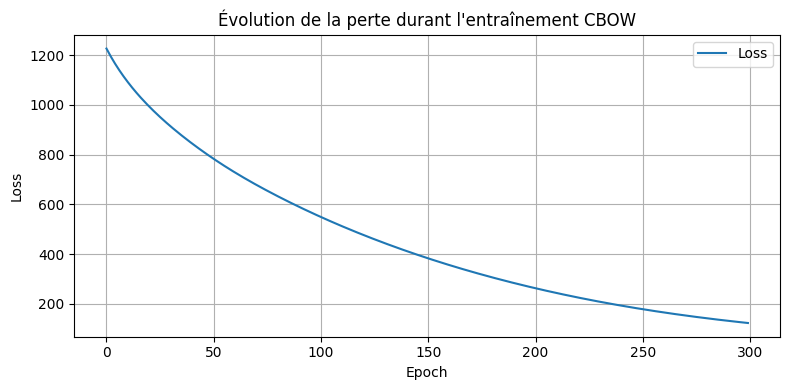

In [14]:
# Graphe d'évolution de la loss

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Évolution de la perte durant l\'entraînement CBOW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> **?**

- Quelles sont les grandes étapes de l'entrainement ?

- Que représente ce graphe ?

______
______
# PRATIQUE : FINE TUNING DE BERT

En partant d'un BERT pré-entrainé, on va l'adapter pour le rendre capable de réaliser une tâche ciblée.


NB : adapté de https://www.kaggle.com/code/mdfahimreshm/bert-finetuning-with-explainability-for-beginners

licence Apache (https://www.apache.org/licenses/LICENSE-2.0)


> **?**

La tâche choisie ici est de déterminer la connotation émotionnelle d'un texte.

Ex : 
- input = "i am feeling grouchy	"
- output = "anger"

A quel type de tâche ceci semble correspondre ?

## Préparation amont

### Librairies

In [15]:
# Importation des libraries

import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizers.__version__: 0.21.1
transformers.__version__: 4.51.3
env: TOKENIZERS_PARALLELISM=true
cuda


### Configuration

In [16]:
# Dossier d'exportation du modèle entrainé

import os

OUTPUT_DIR = './outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [17]:
# Configuration des hyper paramètres

class CFG:
	# Contrôle général / exécution
	train = True  # Mode entraînement (True) ou inférence (False)
	debug = False  # Mode debug pour activer un sous-échantillonage ou désactiver certaines fonctionnalités lourdes
	print_freq = 300  # Fréquence d’affichage (en nombre de batchs)
	seed = 42  # Graine aléatoire pour la reproductibilité
	num_workers = 4  # Nombre de processus pour le chargement des données

	# Modèle et data
	model = 'bert-base-cased'  # ID du modèle préentraîné
	max_len = 512  # Longueur maximale des séquences de tokens
	target_cols = ['label']  # Colonnes cibles à prédire
	num_class = 5  # Nombre de classes dans le jeu de données

	# Entraînement
	epochs = 5 # Nombre d’époques d’entraînement
	batch_size = 32  # Taille des batchs
	gradient_accumulation_steps = 1  # Accumulation de gradients sur plusieurs batchs
	max_grad_norm = 1000  # Norme maximale du gradient (clipping)
	apex = True  # Accélération via calculs en précision mixte (float16)

	# Optimiseur (AdamW)
	learning_rate = 2e-5  # Taux d’apprentissage
	eps = 1e-6  # Terme de stabilité numérique pour l’optimiseur
	betas = (0.9, 0.999)  # Coefficients pour le calcul des moyennes dans Adam
	weight_decay = 0.01  # Paramètre de régularisation pour l’optimiseur

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(CFG.seed)

In [18]:
# Si le mode Debug est activé, alors nous utiliserons un petit ensemble de données d'entraînement

if CFG.debug:
    CFG.epochs = 2
    train = train.sample(frac =.25) 

> **?**

A quoi sert cette classe ?

Qu'est-ce qu'un hyper-paramètre ?

Quels paramètres sont explicites ? Lesquels sont énigmatiques ?

## Préparation des données

### Chargement des données

Le dataset est téléchargé depuis https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

![](assets/page_téléchargement_dataset.png)

In [19]:
# Chargement du dataset

dataset_folder = './dataset/'
train = pd.read_csv(dataset_folder + 'train.txt', names=['text', 'emotion'], sep=';')
valid = pd.read_csv(dataset_folder + 'val.txt', names=['text', 'emotion'], sep=';')
test = pd.read_csv(dataset_folder + 'test.txt', names=['text', 'emotion'], sep=';')

### Inspection des données

In [20]:
# Rapide inspection du dataset

print(f"train.shape: {train.shape}")
display(train.head())

print(f"valid.shape: {valid.shape}")
display(valid.head())

print(f"test.shape: {test.shape}")
display(test.head())


print(train["emotion"].unique())
CFG.num_class = train["emotion"].nunique()
print(CFG.num_class)

train.shape: (16000, 2)


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


valid.shape: (2000, 2)


,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


test.shape: (2000, 2)


,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']
6


> **?**

Qu'entend-t-on par "dataset" d'une manière générale ?

Que contient celui-ci en particulier ?

A quoi correspondent "train", "valid" et "test" ?

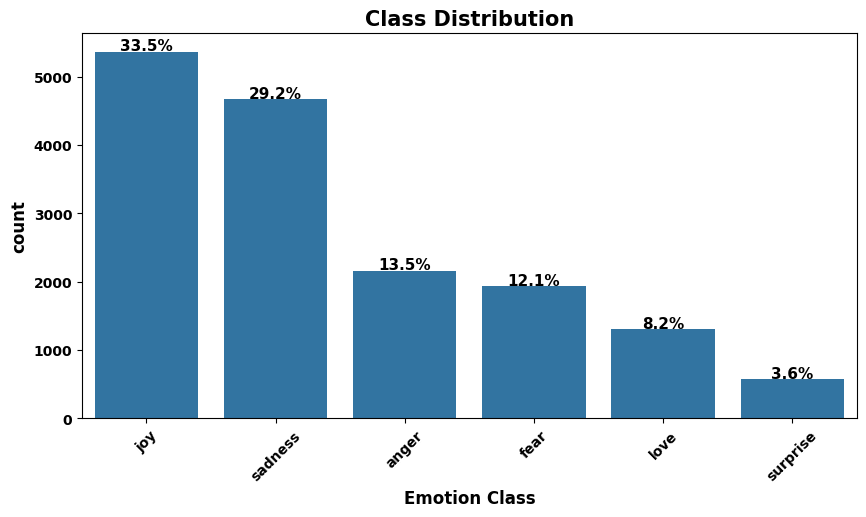

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train))
    ax = sns.countplot(x=col,  data=train, order = train[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

countplot(10,5,'emotion',15,45,'Emotion Class','Class Distribution')

> **?**

Qu'elles sont les classes présentes dans ce corpus ?

Sont elles équilibrées ?

### Convertion des textes en valeurs numériques

In [22]:
# Mapping des labels

mapping = {'sadness' : 0,
           'anger' : 1,
           'love' : 2,
           'surprise' : 3,
           'fear' : 4,
           'joy' : 5,
          }

train['label'] = train['emotion'].map(mapping)
valid['label'] = valid['emotion'].map(mapping)
test['label'] = test['emotion'].map(mapping)

display(train.head())

,text,emotion,label
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,1
3,i am ever feeling nostalgic about the fireplac...,love,2
4,i am feeling grouchy,anger,1


In [23]:
# Instantiation du tokenizer

tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

In [24]:
# Définition de la longeur maximale des séquences

lengths = []
tk0 = tqdm(train['text'].fillna("").values, total=len(train))
for text in tk0:
    length = len(tokenizer(text, truncation=True, add_special_tokens=False)['input_ids'])
    lengths.append(length)
    
if max(lengths) + 2 > 512:
    CFG.max_len = 512
else:
    CFG.max_len = max(lengths) + 2 # cls & sep 

  0%|          | 0/16000 [00:00<?, ?it/s]

In [25]:
# Fonction de préparation des entrées

def prepare_input(cfg, text): #TODO faire 2 versions : une pour l'entraînement et une pour la validation ?
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=CFG.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.long)
        return inputs, label
    

class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        return inputs


def collate(inputs): 
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

> **?**

Que font ces fonction ?

Quelle pourrait être leur utilité ?

## Préparation du modèle

In [26]:

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True, output_attentions=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            
        else:
            self.config = torch.load(config_path, weights_only=False)
            
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.num_class)


    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs.last_hidden_state # Représentations vectorielles contextualisées de chaque token en sortie du dernier bloc de l’encodeur BERT.
        attentions = outputs.attentions # Scores d'attention issus de chaque tête d'attention de chaque couche de BERT
        
        feature = last_hidden_states[:, 0, :] # Embedding du token [CLS] pour chaque élément du batch
        
        output = self.fc(feature)
        return output, attentions

> **?**

Que se passe-t-il à l'initialisation ?

Qu'est ce que la fonction forward ? Et pourquoi ce nom ?

Quelles est la logique globale ici ? 

## Evaluation du modèle avant le fine-tuning

In [27]:
# ====================================================
# CFG for testing
# ====================================================

class CFG_Test:
    num_workers=4
    path=OUTPUT_DIR
    config_path=path+'config.pth'
    model=CFG.model
    batch_size=CFG.batch_size
    target_cols=CFG.target_cols
    seed=CFG.seed
    num_class = CFG.num_class
    
CFG_Test.tokenizer = AutoTokenizer.from_pretrained(CFG_Test.path+'tokenizer/') # load the saved pretrained tokenizer

In [28]:
# Instantiation du modèle
model_initial = CustomModel(cfg=CFG_Test, pretrained=True)
model_initial.to(device)

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [29]:
# Sélection de 3 enregistrements aléatoires du set de test

sample_test_records = test.sample(3, random_state=CFG.seed)
display(sample_test_records)

for _, row in sample_test_records.iterrows():
    inputs = prepare_input(CFG_Test, row['text'])
    for k, v in inputs.items():
        inputs[k] = v.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output, _ = model_initial(inputs)
        pred_label = torch.argmax(output, dim=1).item()
    
    print(f"Input : {row['text']}")
    print(f"Label prédit : {pred_label} ({list(mapping.keys())[list(mapping.values()).index(pred_label)]})")
    print(f"Label réel : {row['label']} ({row['emotion']})")
    print("-" * 50)

,text,emotion,label
1860,i feel so dirty but after spending a day at th...,sadness,0
353,i could feel his breath on me and smell the sw...,joy,5
1333,i just want to feel loved by you,love,2


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Input : i feel so dirty but after spending a day at the mk show me and a buddy decided we would get the two player starter between us luckily for us both i liked the everblight and he liked the circle maybe a tad to much so it all worked out well
Label prédit : 1 (anger)
Label réel : 0 (sadness)
--------------------------------------------------
Input : i could feel his breath on me and smell the sweet scent of him
Label prédit : 1 (anger)
Label réel : 5 (joy)
--------------------------------------------------
Input : i just want to feel loved by you
Label prédit : 1 (anger)
Label réel : 2 (love)
--------------------------------------------------


#### Mesure de performance : application au dataset de test

In [30]:
# Fonction pour l'inférence

def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0: # iterate over the test data
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs) # considering the logits only
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import DataCollatorWithPadding
test_dataset = TestDataset(CFG_Test, test)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG_Test.batch_size,
                         shuffle=False,
                         collate_fn=DataCollatorWithPadding(tokenizer=CFG_Test.tokenizer, padding='longest'))
                         

prediction = inference_fn(test_loader, model_initial, device)

del model_initial; gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/63 [00:00<?, ?it/s]

In [32]:
final_prediction = prediction.argmax(axis = 1) #FIXME Questionner sur ce qu'on fait ici
test['Prediction'] = final_prediction

display(test.head())

labels_reels = test['label'].tolist()
labels_predits = test['Prediction'].tolist()

,text,emotion,label,Prediction
0,im feeling rather rotten so im not very ambiti...,sadness,0,1
1,im updating my blog because i feel shitty,sadness,0,1
2,i never make her separate from me because i do...,sadness,0,1
3,i left with my bouquet of red and yellow tulip...,joy,5,1
4,i was feeling a little vain when i did this one,sadness,0,1


In [33]:
# Génération du rapport de classification

print(classification_report(labels_reels, labels_predits, digits = 4))

              precision    recall  f1-score   support

           0     0.0769    0.0017    0.0034       581
           1     0.1384    1.0000    0.2431       275
           2     0.0000    0.0000    0.0000       159
           3     0.0000    0.0000    0.0000        66
           4     0.0000    0.0000    0.0000       224
           5     0.0000    0.0000    0.0000       695

    accuracy                         0.1380      2000
   macro avg     0.0359    0.1670    0.0411      2000
weighted avg     0.0414    0.1380    0.0344      2000



> **?**

Quelles sont ses métriques ? 

Comment les interpréter ?

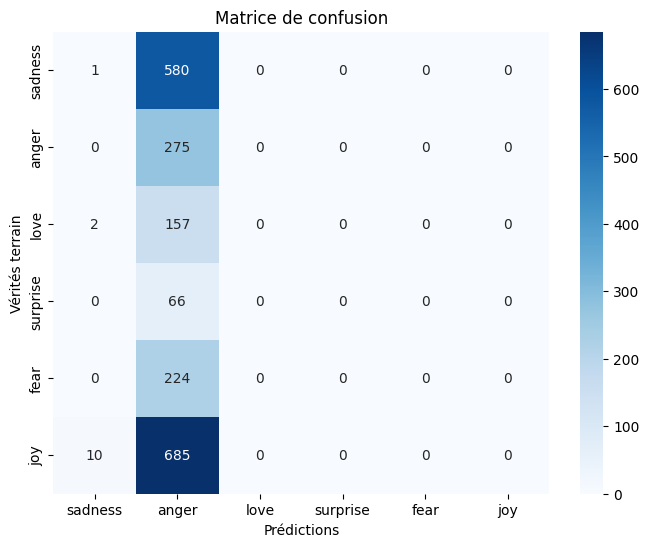

In [34]:
# Matrice de confusion

def plot_matrice_confusion(labels_reels, labels_predits):
    conf_matrix = confusion_matrix(labels_reels, labels_predits)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mapping.keys(), yticklabels=mapping.keys())
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités terrain')
    plt.title('Matrice de confusion')
    plt.show()


plot_matrice_confusion(labels_reels, labels_predits)

> **?**

Que voit-on explicitement ici sur cette matrice de confusion ?

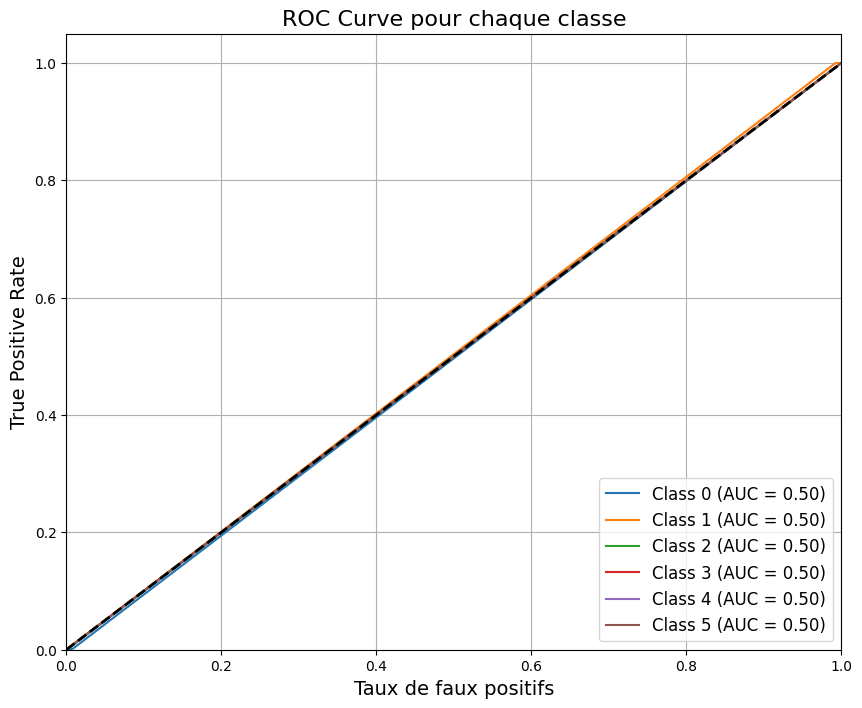

In [35]:
# ROC curve pour chaque classe

def plot_roc_curve(labels_reels, labels_predits):

    # Convertion en une forme binaire (pour chaque classe)
    classes = list(mapping.values())
    y_test_binarized = label_binarize(labels_reels, classes=classes)
    y_pred_binarized = label_binarize(labels_predits, classes=classes)

    # Calcul des faux positifs et vrais positifs
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve pour chaque classe', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.show()


plot_roc_curve(labels_reels, labels_predits)

> **?**

Qu'est-ce qu'une courbe ROC ?

A quoi sert-elle ?

> **?**

Globalement, ces performances avant l'entrainement font elles sens ?

## Entrainement du modèle

In [36]:
# Fonctions utilitaires pour l'entraînement et la validation

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val - n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m - 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:

def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    
    model.train()
    
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex) 
    
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    for step, (inputs, labels) in enumerate(train_loader):  
        inputs = collate(inputs) 
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)  
        labels = labels.to(device) 
        batch_size = labels.size(0)
        
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs) 
            loss = criterion(y_preds.view(-1, CFG.num_class), labels.view(-1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
    

        scaler.scale(loss).backward() 
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm) # 
        
        losses.update(loss.item(), batch_size)
        
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        end = time.time()
        
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm))

    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    
    for step, (inputs, labels) in enumerate(valid_loader):  
        inputs = collate(inputs)
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        with torch.no_grad():
            y_preds, _ = model(inputs)
            loss = criterion(y_preds.view(-1, CFG.num_class), labels.view(-1))
            
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

> **?**

Que fait chacune de ces fonction ?

A quoi peuvent elles servir ?

Quelles sont les grandes étapes de train_fn ?

### Boucle d'entrainement

In [38]:
from sklearn.metrics import f1_score

def get_score(y_trues, y_preds):
    y_predicted = y_preds.argmax(axis=1)  # Convertion des probababilité pour chaque classe en label prédit
    macro_f1 = f1_score(y_trues, y_predicted, average='macro')
    return macro_f1

In [39]:
# Boucle d'entraînement

def train_loop():

    # Chargement des données
    train_dataset = TrainDataset(CFG, train) 
    valid_dataset = TrainDataset(CFG, valid) 

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True) 

    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False) 
                            
    valid_labels = valid[CFG.target_cols].values
    
    # Chargement du modèle et de l'optimiseur
    model = CustomModel(CFG, config_path=None, pretrained=True)  
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device) 
    
    optimizer = AdamW(model.parameters(), lr=CFG.learning_rate, eps=CFG.eps, betas=CFG.betas) 
    
    # Choix d'une loss function
    criterion = nn.CrossEntropyLoss(reduction="mean")
    best_score = 0

    train_losses = []
    valid_losses = []
    for epoch in range(CFG.epochs):

        start_time = time.time()

        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, device)
        train_losses.append(avg_loss)

        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        valid_losses.append(avg_val_loss)

        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        
        if best_score < score: # On sauvegarde le modèle si le score est meilleur que le précédent
            best_score = score

            file_name = "bert_entrainé.pth" #Par commodité, on va utiliser un nom de fichier fixé en dur. Une alternative serait de le nommer avec le score f"{CFG.model.replace('/', '-')}_score{best_score:.4f}_best.pth" #TODO passer le nom dans CFG 
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+file_name 
                        )

    predictions = torch.load(OUTPUT_DIR+file_name, 
                             map_location=torch.device('cpu'), weights_only=False)['predictions'] #Nécessaire pour s'assurer de charger les prédictions du modèle à l'itération ayant le meilleur score
    final_pred = predictions.argmax(axis=1)
    final_pred = final_pred.tolist()
    valid[f"pred_label"] = final_pred

    torch.cuda.empty_cache()
    gc.collect()
    

    return valid, best_score, train_losses, valid_losses

> **?**

Qu'est ce qu'une epoch ?

A quoi sert la loss dans le processus d'entrainement ?

Qu'est ce que `criterion` ?

Quel est le rôle de l'optimiser ?

In [40]:
# Appliquation de l'entrainement du modèle

valid, best_score, train_losses, valid_losses = train_loop()

Epoch: [1][0/500] Elapsed 0m 60s (remain 3m 278s) Loss: 1.7960(-0.9439) Grad: inf  
Epoch: [1][300/500] Elapsed 0m 118s (remain 0m 98s) Loss: 0.2296(-0.9814) Grad: 69959.8047  
Epoch: [1][499/500] Elapsed 1m 156s (remain 0m 60s) Loss: 0.1126(-0.9864) Grad: 55583.1523  
EVAL: [0/32] Elapsed 0m 60s (remain 0m 70s) Loss: 0.1285(-0.9980) 
EVAL: [31/32] Elapsed 0m 64s (remain 0m 60s) Loss: 0.1663(-0.9974) 
Epoch: [2][0/500] Elapsed 0m 60s (remain 2m 209s) Loss: 0.0590(-0.9982) Grad: 70770.7500  
Epoch: [2][300/500] Elapsed 0m 119s (remain 0m 99s) Loss: 0.0145(-0.9965) Grad: 164107.7812  
Epoch: [2][499/500] Elapsed 1m 158s (remain 0m 60s) Loss: 0.0927(-0.9964) Grad: 47835.0781  
EVAL: [0/32] Elapsed 0m 60s (remain 0m 69s) Loss: 0.1406(-0.9978) 
EVAL: [31/32] Elapsed 0m 64s (remain 0m 60s) Loss: 0.0907(-0.9978) 
Epoch: [3][0/500] Elapsed 0m 60s (remain 2m 237s) Loss: 0.1206(-0.9962) Grad: 152738.9531  
Epoch: [3][300/500] Elapsed 1m 120s (remain 0m 100s) Loss: 0.0585(-0.9974) Grad: 82997.117

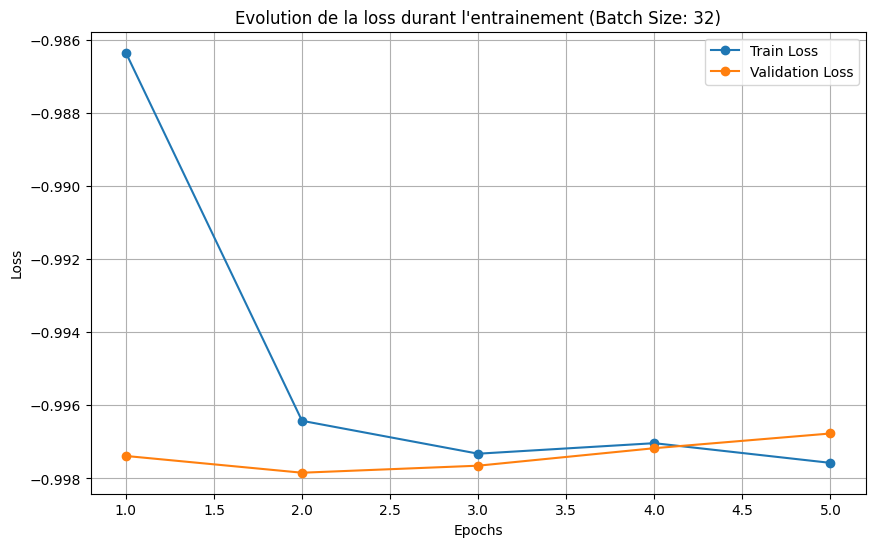

In [41]:
# Graphe d'évolution de la loss durant l'entrainement

plt.figure(figsize=(10, 6))
plt.plot(range(1, CFG.epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, CFG.epochs + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"Evolution de la loss durant l'entrainement (Batch Size: {CFG.batch_size})")
plt.legend()
plt.grid(True)
plt.show()

> **?**

Comment interpréter ces courbes ? 

Quelle est leur utilité ?

## Evaluation du modèle fine tunné

In [42]:
# Chargement du modèle fine-tune

trained_model = CustomModel(CFG_Test, config_path=CFG_Test.config_path, pretrained=False)
state = torch.load(OUTPUT_DIR+f"bert_entrainé.pth",
                   map_location=torch.device('cpu'), weights_only=False) 
trained_model.load_state_dict(state['model'])

<All keys matched successfully>

In [43]:
# Génération des inférences sur le set d'évaluation

prediction = inference_fn(test_loader, trained_model, device)
final_prediction = prediction.argmax(axis = 1)
test['Prediction'] = final_prediction
display(test.head())

labels_reels = test['label'].tolist()
labels_predits = test['Prediction'].tolist()

  0%|          | 0/63 [00:00<?, ?it/s]

,text,emotion,label,Prediction
0,im feeling rather rotten so im not very ambiti...,sadness,0,0
1,im updating my blog because i feel shitty,sadness,0,0
2,i never make her separate from me because i do...,sadness,0,0
3,i left with my bouquet of red and yellow tulip...,joy,5,5
4,i was feeling a little vain when i did this one,sadness,0,0


In [44]:
# Génération du rapport de classification

print(classification_report(labels_reels, labels_predits, digits = 4))

              precision    recall  f1-score   support

           0     0.9603    0.9587    0.9595       581
           1     0.9361    0.9055    0.9205       275
           2     0.8696    0.7547    0.8081       159
           3     0.7458    0.6667    0.7040        66
           4     0.8739    0.8973    0.8855       224
           5     0.9175    0.9597    0.9381       695

    accuracy                         0.9190      2000
   macro avg     0.8839    0.8571    0.8693      2000
weighted avg     0.9181    0.9190    0.9180      2000



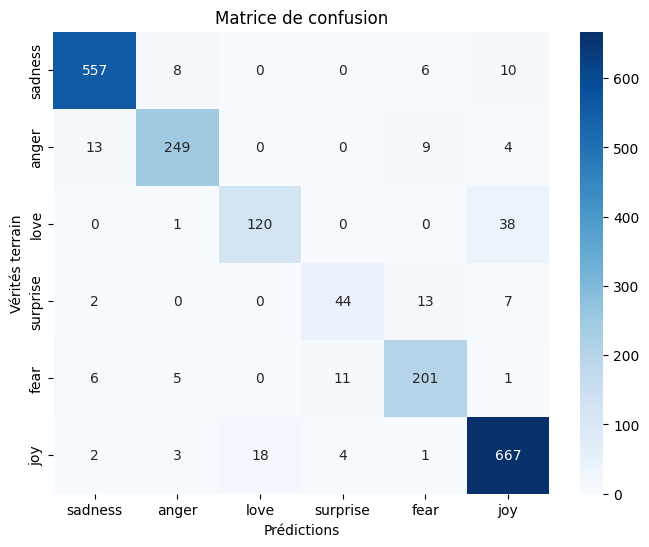

In [45]:
# Matrice de confusion

plot_matrice_confusion(labels_reels, labels_predits)

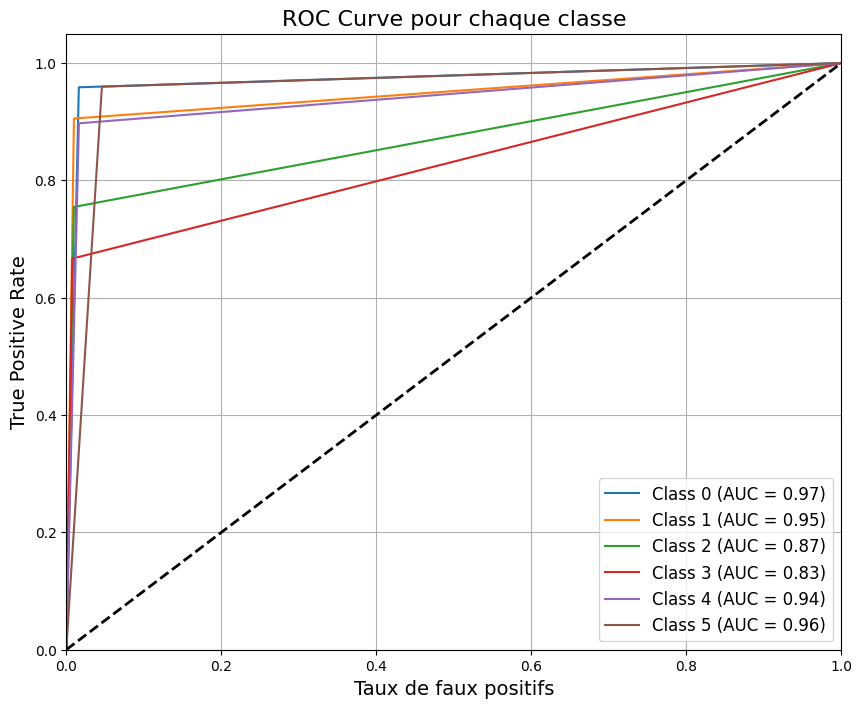

In [46]:
# ROC curve pour chaque classe

plot_roc_curve(labels_reels, labels_predits)